# Tutorial on Online Non-Negative Matrix Factorization

This notebooks explains basic ideas behind NMF implementation, training examples and use-cases.

**Matrix Factorizations** are useful for many things: recomendation systems, bi-clustering, image compression and, in particular, topic modeling.

Why **Non-Negative**? It makes the problem more strict and allows us to apply some optimizations.

Why **Online**? Because corpora are large and RAM is limited. Online NMF can learn topics iteratively.

This particular implementation is based on [this paper](https://arxiv.org/abs/1604.02634).

The main attributes are following:

- W is a word-topic matrix
- h is a topic-document matrix
- v is an input word-document matrix
- A, B - matrices that accumulate information from every consecutive chunk. A = h.dot(ht), B = v.dot(ht).

The idea of the algorithm is as follows:

```
    Initialize W, A and B matrices

    Input corpus
    Split corpus to batches

    for v in batches:
        infer h:
            do coordinate gradient descent step to find h that minimizes (v - Wh) l2 norm

            bound h so that it is non-negative

        update A and B:
            A = h.dot(ht)
            B = v.dot(ht)

        update W:
            do gradient descent step to find W that minimizes 0.5*trace(WtWA) - trace(WtB) l2 norm
```

## What's in this tutorial?

- Basic training example
- Comparison with alternative models (LDA and Sklearn NMF)
- Non-standart application (image decomposition)

## Preprocessing

In [1]:
%load_ext autoreload
%load_ext line_profiler

%autoreload 2

import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

import gensim.downloader as api
from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Dataset preprocessing

In [2]:
newsgroups = api.load('20-newsgroups')

categories = [
    'alt.atheism',
    'comp.graphics',
    'rec.motorcycles',
    'talk.politics.mideast',
    'sci.space'
]

categories = {
    name: idx
    for idx, name
    in enumerate(categories)
}

In [3]:
random_state = RandomState(42)

trainset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc
    in newsgroups
    if doc['topic'] in categories
    and doc['set'] == 'train'
])
random_state.shuffle(trainset)

testset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc
    in newsgroups
    if doc['topic'] in categories
    and doc['set'] == 'test'
])
random_state.shuffle(testset)

In [4]:
train_documents = [preprocess_string(doc['data']) for doc in trainset]
test_documents = [preprocess_string(doc['data']) for doc in testset]

### Dictionary compilation

In [5]:
dictionary = Dictionary(train_documents)
dictionary.filter_extremes()

2019-02-04 15:38:01,455 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-02-04 15:38:02,052 : INFO : built Dictionary(25279 unique tokens: ['actual', 'assum', 'babbl', 'batka', 'batkaj']...) from 2819 documents (total 435328 corpus positions)
2019-02-04 15:38:02,100 : INFO : discarding 18198 tokens: [('batka', 1), ('batkaj', 1), ('beatl', 1), ('ccmail', 3), ('dayton', 4), ('edu', 1785), ('inhibit', 1), ('jbatka', 1), ('line', 2748), ('organ', 2602)]...
2019-02-04 15:38:02,101 : INFO : keeping 7081 tokens which were in no less than 5 and no more than 1409 (=50.0%) documents
2019-02-04 15:38:02,114 : INFO : resulting dictionary: Dictionary(7081 unique tokens: ['actual', 'assum', 'babbl', 'burster', 'caus']...)


### Corpora compilation

In [6]:
train_corpus = [
    dictionary.doc2bow(document)
    for document
    in train_documents
]

test_corpus = [
    dictionary.doc2bow(document)
    for document
    in test_documents
]

## Training

The API works in the way similar to [Gensim.models.LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html).

Special parameters:

- `kappa` float, optional

    Gradient descent step size.
    
    Larger value makes the model train faster, but could lead to non-convergence if set too large.
    
    
- `w_max_iter` int, optional

    Maximum number of iterations to train W per each batch.
    
    
- `w_stop_condition` float, optional

    If error difference gets less than that, training of ``W`` stops for the current batch.
    
    
- `h_r_max_iter` int, optional

    Maximum number of iterations to train h per each batch.
    
    
- `h_r_stop_condition` float

    If error difference gets less than that, training of ``h`` stops for the current batch.

In [7]:
%%time

nmf = GensimNmf(
    corpus=train_corpus,
    num_topics=5,
    id2word=dictionary,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=42,
    kappa=1,
)

2019-02-04 15:38:03,302 : INFO : Loss: 0.027239404991752342
2019-02-04 15:38:03,493 : INFO : Loss: 0.01979737390324471


CPU times: user 657 ms, sys: 298 µs, total: 657 ms
Wall time: 656 ms


### Topics

In [8]:
nmf.show_topics()

[(0,
  '0.017*"armenian" + 0.015*"peopl" + 0.014*"said" + 0.013*"know" + 0.008*"went" + 0.008*"sai" + 0.007*"like" + 0.007*"apart" + 0.007*"come" + 0.007*"azerbaijani"'),
 (1,
  '0.074*"jpeg" + 0.032*"file" + 0.031*"gif" + 0.028*"imag" + 0.024*"color" + 0.017*"format" + 0.014*"qualiti" + 0.013*"convert" + 0.013*"compress" + 0.013*"version"'),
 (2,
  '0.030*"imag" + 0.014*"graphic" + 0.012*"data" + 0.010*"file" + 0.010*"pub" + 0.010*"ftp" + 0.010*"avail" + 0.008*"format" + 0.008*"program" + 0.008*"packag"'),
 (3,
  '0.015*"god" + 0.012*"atheist" + 0.009*"believ" + 0.009*"exist" + 0.008*"atheism" + 0.007*"peopl" + 0.007*"religion" + 0.006*"christian" + 0.006*"israel" + 0.006*"religi"'),
 (4,
  '0.028*"space" + 0.019*"launch" + 0.013*"satellit" + 0.009*"orbit" + 0.008*"nasa" + 0.007*"year" + 0.007*"mission" + 0.006*"new" + 0.006*"commerci" + 0.005*"market"')]

### Coherence

Here's a [description of what coherence is](http://qpleple.com/topic-coherence-to-evaluate-topic-models/). Basically it measures how often do most frequent tokens from each topic co-occur in one document.

In [9]:
CoherenceModel(
    model=nmf,
    corpus=test_corpus,
    coherence='u_mass'
).get_coherence()

2019-02-04 15:38:03,611 : INFO : CorpusAccumulator accumulated stats from 1000 documents


-1.7053902612634844

### Perplexity

[Perplexity](http://qpleple.com/perplexity-to-evaluate-topic-models/) is basically a degree of uncertainty of the model, i.e. how probable it is to observe a particular set of documents.

In [10]:
np.exp(-nmf.log_perplexity(test_corpus))

2501.280703411481

### Document topics inference

Let's get some news and infer a topic vector.

In [11]:
print(testset[0]['data'])
print('=' * 100)
print("Topics: {}".format(nmf[test_corpus[0]]))

From: spl@ivem.ucsd.edu (Steve Lamont)
Subject: Re: RGB to HVS, and back
Organization: University of Calif., San Diego/Microscopy and Imaging Resource
Lines: 18
Distribution: world
NNTP-Posting-Host: ivem.ucsd.edu

In article <ltu4buINNe7j@caspian.usc.edu> zyeh@caspian.usc.edu (zhenghao yeh) writes:
>|> See Foley, van Dam, Feiner, and Hughes, _Computer Graphics: Principles
>|> and Practice, Second Edition_.
>|> 
>|> [If people would *read* this book, 75 percent of the questions in this
>|> froup would disappear overnight...]
>|> 
>	Not really. I think it is less than 10%.

Nah... I figure most people would be so busy reading that they wouldn't
have *time* to post. :-) :-) :-)

							spl
-- 
Steve Lamont, SciViGuy -- (619) 534-7968 -- spl@szechuan.ucsd.edu
San Diego Microscopy and Imaging Resource/UC San Diego/La Jolla, CA 92093-0608
"Until I meet you, then, in Upper Hell
Convulsed, foaming immortal blood: farewell" - J. Berryman, "A Professor's Song"

Topics: [(0, 0.29903293372372697)

### Word topic inference

Here's an example of topic distribution inference for a token.

In [12]:
word = dictionary[0]
print("Word: {}".format(word))
print("Topics: {}".format(nmf.get_term_topics(word)))

Word: actual
Topics: [(0, 0.04910674896578284), (1, 0.1277766177062051), (2, 0.07803764680331245), (3, 0.6584104509982174), (4, 0.08666853552648228)]


### Internal state

Density is a fraction of non-zero elements in a matrix.

In [13]:
def density(matrix):
    return (matrix > 0).mean()

Term-topic matrix of shape `(words, topics)`.

In [14]:
print("Density: {}".format(density(nmf._W)))

Density: 0.6427905663041943


Topic-document matrix for the last batch of shape `(topics, batch)`

In [15]:
print("Density: {}".format(density(nmf._h)))

Density: 0.8424908424908425


Residuals matrix of the last batch of shape `(words, batch)`

# Benchmarks

## Gensim NMF vs Sklearn NMF vs Gensim LDA

We'll run all the models on the [20newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) dataset, which has texts and labels for them.

### Metrics

- train time: time to train a model in seconds
- coherence: coherence score (not defined for sklearn NMF). Classic metric for topic models.
- perplexity: perplexity score. Another usual TM metric
- f1: f1 on the task of news topic classification
- l2_norm: l2 matrix norm

In [16]:
fixed_params = dict(
    corpus=train_corpus,
    chunksize=1000,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=42,
)

In [17]:
def get_execution_time(func):
    start = time.time()
    result = func()

    return (time.time() - start), result


def get_tm_f1(model, train_corpus, X_test, y_train, y_test):
    X_train = np.zeros((len(train_corpus), model.num_topics))
    for bow_id, bow in enumerate(train_corpus):
        for topic_id, factor in model.get_document_topics(bow):
            X_train[bow_id, topic_id] = factor

    log_reg = LogisticRegressionCV(multi_class='multinomial')
    log_reg.fit(X_train, y_train)

    pred_labels = log_reg.predict(X_test)

    return f1_score(y_test, pred_labels, average='micro')


def get_sklearn_f1(model, train_corpus, X_test, y_train, y_test):
    X_train = model.transform(train_corpus.T)

    log_reg = LogisticRegressionCV(multi_class='multinomial')
    log_reg.fit(X_train, y_train)

    pred_labels = log_reg.predict(X_test)

    return f1_score(y_test, pred_labels, average='micro')


def get_tm_metrics(model, train_corpus, test_corpus, dense_corpus, y_train, y_test):
    W = model.get_topics().T
    H = np.zeros((model.num_topics, len(test_corpus)))
    for bow_id, bow in enumerate(test_corpus):
        for topic_id, factor in model.get_document_topics(bow):
            H[topic_id, bow_id] = factor

    pred_factors = W.dot(H)
    
    l2_norm = get_tm_l2_norm(pred_factors, dense_corpus)
    
    pred_factors /= pred_factors.sum(axis=0)

    perplexity = get_tm_perplexity(pred_factors, dense_corpus)

    f1 = get_tm_f1(model, train_corpus, H.T, y_train, y_test)

    model.normalize = True

    coherence = CoherenceModel(
        model=model,
        corpus=test_corpus,
        coherence='u_mass'
    ).get_coherence()
    
    topics = model.show_topics(5)

    model.normalize = False

    return dict(
        perplexity=perplexity,
        coherence=coherence,
        l2_norm=l2_norm,
        f1=f1,
        topics=topics,
    )


def get_tm_perplexity(pred_factors, dense_corpus):
    return np.exp(-(np.log(pred_factors, where=pred_factors > 0) * dense_corpus).sum() / dense_corpus.sum())


def get_tm_l2_norm(pred_factors, dense_corpus):
    return np.linalg.norm(dense_corpus - pred_factors)


def get_sklearn_topics(model, id2word, top_n=5):
    topic_probas = model.components_.T
    topic_probas = topic_probas / topic_probas.sum(axis=0)
    
    sparsity = np.zeros(topic_probas.shape[1])

    for row in topic_probas:
        sparsity += (row == 0)

    sparsity /= topic_probas.shape[1]
    
    topic_probas = topic_probas[:, sparsity.argsort()[::-1]][:, :top_n]
    
    token_indices = topic_probas.argsort(axis=0)[:-11:-1, :]
    topic_probas.sort(axis=0)
    topic_probas = topic_probas[:-11:-1, :]
    
    topics = []
    
    for topic_idx in range(topic_probas.shape[1]):
        tokens = [
            id2word[token_idx]
            for token_idx
            in token_indices[:, topic_idx]
        ]
        topic = (
            '{}*"{}"'.format(round(proba, 3), token)
            for proba, token
            in zip(topic_probas[:, topic_idx], tokens)
        )
        topic = " + ".join(topic)
        topics.append((topic_idx, topic))
    
    return topics


def get_sklearn_metrics(model, train_corpus, test_corpus, y_train, y_test, dictionary):
    W = model.components_.T
    H = model.transform((test_corpus).T).T
    pred_factors = W.dot(H)
    
    l2_norm = np.linalg.norm(test_corpus - pred_factors)
    
    pred_factors /= pred_factors.sum(axis=0)
    
    perplexity = np.exp(
        -(np.log(pred_factors, where=pred_factors > 0) * test_corpus).sum()
        / test_corpus.sum()
    )

    f1 = get_sklearn_f1(model, train_corpus, H.T, y_train, y_test)
    
    topics = get_sklearn_topics(model, dictionary, top_n=5)

    return dict(
        perplexity=perplexity,
        l2_norm=l2_norm,
        f1=f1,
        topics=topics,
    )

### Run the models

In [18]:
tm_metrics = pd.DataFrame(columns=['model', 'train_time', 'perplexity', 'coherence', 'l2_norm', 'f1', 'topics'])

train_dense_corpus = matutils.corpus2dense(train_corpus, len(dictionary))
test_dense_corpus = matutils.corpus2dense(test_corpus, len(dictionary))

trainset_target = [doc['target'] for doc in trainset]
testset_target = [doc['target'] for doc in testset]

# LDA metrics
row = dict()
row['model'] = 'lda'
row['train_time'], lda = get_execution_time(
    lambda: LdaModel(**fixed_params)
)
row.update(get_tm_metrics(
    lda, train_corpus, test_corpus, test_dense_corpus, trainset_target, testset_target,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

# Sklearn NMF metrics
row = dict()
row['model'] = 'sklearn_nmf'
sklearn_nmf = SklearnNmf(n_components=5, tol=1e-5, max_iter=int(1e9), random_state=42)
row['train_time'], sklearn_nmf = get_execution_time(
    lambda: sklearn_nmf.fit((train_dense_corpus).T)
)
row.update(get_sklearn_metrics(
    sklearn_nmf, train_dense_corpus, test_dense_corpus, trainset_target, testset_target, dictionary
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

row = dict()
row['model'] = 'gensim_nmf'
row['train_time'], gensim_nmf = get_execution_time(
    lambda: GensimNmf(
        normalize=False,
        **fixed_params
    )
)
row.update(get_tm_metrics(
    gensim_nmf, train_corpus, test_corpus, test_dense_corpus, trainset_target, testset_target,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)
tm_metrics.replace(np.nan, '-', inplace=True)

2019-02-04 15:38:06,382 : INFO : using symmetric alpha at 0.2
2019-02-04 15:38:06,383 : INFO : using symmetric eta at 0.2
2019-02-04 15:38:06,385 : INFO : using serial LDA version on this node
2019-02-04 15:38:06,392 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 2819 documents, updating model once every 1000 documents, evaluating perplexity every 2819 documents, iterating 50x with a convergence threshold of 0.001000
2019-02-04 15:38:06,392 : INFO : PROGRESS: pass 0, at document #1000/2819
2019-02-04 15:38:07,220 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-02-04 15:38:07,224 : INFO : topic #0 (0.200): 0.006*"com" + 0.005*"new" + 0.005*"peopl" + 0.004*"space" + 0.004*"like" + 0.004*"univers" + 0.004*"time" + 0.004*"nntp" + 0.004*"armenian" + 0.004*"host"
2019-02-04 15:38:07,227 : INFO : topic #1 (0.200): 0.007*"com" + 0.005*"like" + 0.005*"peopl" + 0.005*"know" + 0.004*"think" + 0.004*"time" + 0.004*

2019-02-04 15:38:12,355 : INFO : topic diff=0.423402, rho=0.455535
2019-02-04 15:38:12,356 : INFO : PROGRESS: pass 2, at document #1000/2819
2019-02-04 15:38:12,945 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-02-04 15:38:12,949 : INFO : topic #0 (0.200): 0.009*"space" + 0.007*"com" + 0.006*"bike" + 0.006*"new" + 0.005*"univers" + 0.005*"orbit" + 0.004*"nasa" + 0.004*"year" + 0.004*"like" + 0.004*"time"
2019-02-04 15:38:12,950 : INFO : topic #1 (0.200): 0.010*"com" + 0.009*"god" + 0.007*"peopl" + 0.007*"like" + 0.007*"think" + 0.006*"know" + 0.006*"thing" + 0.006*"moral" + 0.005*"time" + 0.005*"atheist"
2019-02-04 15:38:12,952 : INFO : topic #2 (0.200): 0.012*"israel" + 0.010*"isra" + 0.007*"jew" + 0.007*"peopl" + 0.006*"arab" + 0.006*"islam" + 0.005*"right" + 0.005*"think" + 0.005*"state" + 0.004*"univers"
2019-02-04 15:38:12,953 : INFO : topic #3 (0.200): 0.013*"imag" + 0.009*"file" + 0.009*"graphic" + 0.009*"com" + 0.007*"program" + 0.006*"us" + 0

2019-02-04 15:38:17,856 : INFO : topic #1 (0.200): 0.011*"com" + 0.011*"god" + 0.008*"peopl" + 0.007*"think" + 0.007*"like" + 0.006*"thing" + 0.006*"know" + 0.006*"moral" + 0.005*"atheist" + 0.005*"time"
2019-02-04 15:38:17,857 : INFO : topic #2 (0.200): 0.013*"israel" + 0.011*"isra" + 0.009*"jew" + 0.007*"arab" + 0.007*"peopl" + 0.006*"islam" + 0.006*"right" + 0.005*"state" + 0.005*"think" + 0.004*"peac"
2019-02-04 15:38:17,859 : INFO : topic #3 (0.200): 0.014*"imag" + 0.010*"file" + 0.010*"graphic" + 0.008*"com" + 0.008*"program" + 0.006*"us" + 0.006*"univers" + 0.005*"softwar" + 0.005*"host" + 0.005*"jpeg"
2019-02-04 15:38:17,860 : INFO : topic #4 (0.200): 0.019*"armenian" + 0.011*"turkish" + 0.010*"peopl" + 0.006*"said" + 0.006*"armenia" + 0.006*"turk" + 0.005*"turkei" + 0.005*"know" + 0.004*"greek" + 0.004*"year"
2019-02-04 15:38:17,862 : INFO : topic diff=0.204471, rho=0.357622
2019-02-04 15:38:17,863 : INFO : PROGRESS: pass 4, at document #2000/2819
2019-02-04 15:38:18,430 : INF

## Result table

In [19]:
tm_metrics.drop('topics', axis=1)

,model,train_time,perplexity,coherence,l2_norm,f1
0,lda,13.318739,1939.575705,-1.75565,1189.615303,0.765458
1,sklearn_nmf,11.887893,2498.645238,-,895.547301,0.706290
2,gensim_nmf,0.715953,2475.979773,-1.70539,898.492705,0.715352


### Main insights

- Gensim NMF is **ridiculously** fast and leaves LDA and Sklearn far behind in terms of training time
- Gensim NMF beats sklearn NMF implementation on f1 metric, though not on the l2 norm
- Gensim NMF beats LDA on coherence, but LDA is still better on perplexity

### Topics

In [20]:
def compare_topics(tm_metrics):
    for _, row in tm_metrics.iterrows():
        print('\n{}:'.format(row.model))
        print("\n".join(str(topic) for topic in row.topics))
        
compare_topics(tm_metrics)


lda:
(0, '0.014*"space" + 0.008*"com" + 0.007*"bike" + 0.007*"nasa" + 0.005*"new" + 0.005*"orbit" + 0.005*"launch" + 0.005*"year" + 0.005*"univers" + 0.004*"like"')
(1, '0.011*"god" + 0.011*"com" + 0.008*"peopl" + 0.008*"think" + 0.007*"like" + 0.006*"thing" + 0.006*"know" + 0.005*"moral" + 0.005*"believ" + 0.005*"time"')
(2, '0.013*"israel" + 0.011*"isra" + 0.010*"jew" + 0.007*"arab" + 0.007*"peopl" + 0.006*"state" + 0.006*"islam" + 0.006*"right" + 0.005*"think" + 0.004*"jewish"')
(3, '0.012*"imag" + 0.010*"graphic" + 0.010*"file" + 0.008*"com" + 0.008*"program" + 0.006*"softwar" + 0.006*"univers" + 0.006*"us" + 0.005*"mail" + 0.005*"host"')
(4, '0.020*"armenian" + 0.012*"turkish" + 0.010*"peopl" + 0.007*"said" + 0.006*"turkei" + 0.006*"armenia" + 0.006*"turk" + 0.005*"know" + 0.004*"greek" + 0.004*"year"')

sklearn_nmf:
(0, '0.053*"jpeg" + 0.039*"imag" + 0.028*"file" + 0.023*"gif" + 0.019*"color" + 0.016*"format" + 0.011*"version" + 0.011*"program" + 0.011*"bit" + 0.01*"qualiti"')
(

NMF's are on par with each other, LDA looks a bit worse.

## Faces Dataset Decomposition + Gensim NMF

NMF algorithm works not only with texts, but with all kinds of stuff!

Let's compare our model with the other factorization algorithms and check out the results!

To do that we'll patch sklearn's [Faces Dataset Decomposition](https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html).

### Sklearn wrapper
Let's create a wrapper to compare Gensim NMF with the other factorizations on images

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.sparse as sparse


class NmfWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, bow_matrix, **kwargs):
        self.corpus = sparse.csc.csc_matrix(bow_matrix)
        self.nmf = GensimNmf(**kwargs)

    def fit(self, X):
        self.nmf.update(self.corpus)

    @property
    def components_(self):
        return self.nmf.get_topics()

### Modified FDD notebook


Faces dataset decompositions

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.149s
Extracting the top 6 Non-negative components - NMF (Sklearn)...
done in 0.764s
Extracting the top 6 Non-negative components - NMF (Gensim)...


2019-02-04 15:38:48,676 : INFO : Loss: 0.0006492720380652716


done in 0.750s
Extracting the top 6 Independent components - FastICA...
done in 0.424s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 1.350s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 2.393s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.180s
Extracting the top 6 Factor Analysis components - FA...


/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/site-packages/sklearn/decomposition/factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


done in 0.344s


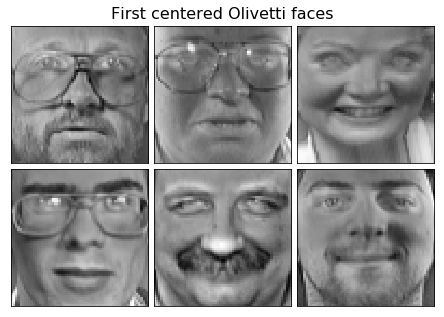

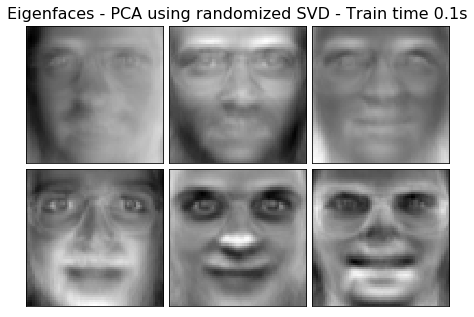

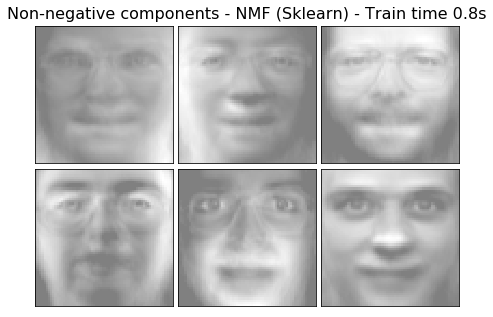

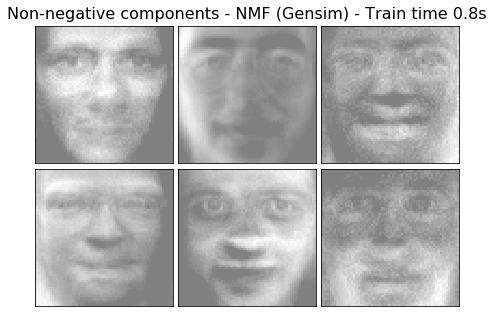

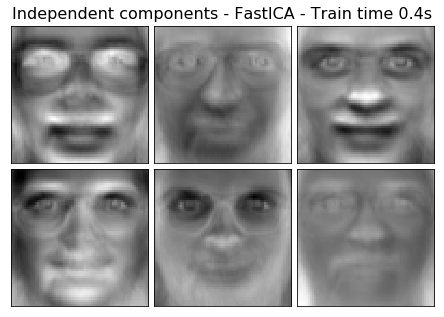

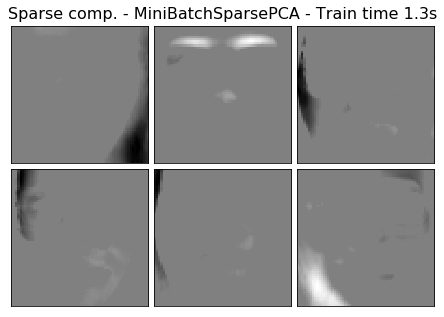

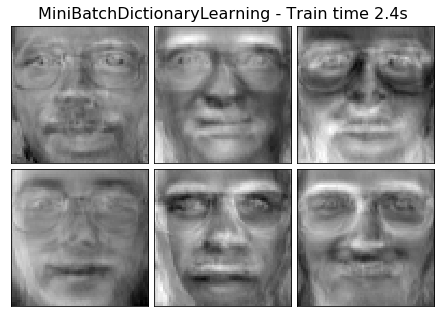

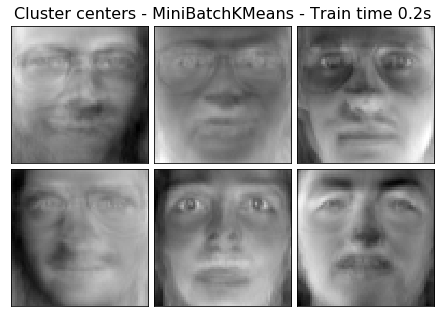

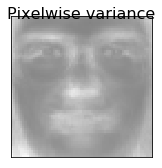

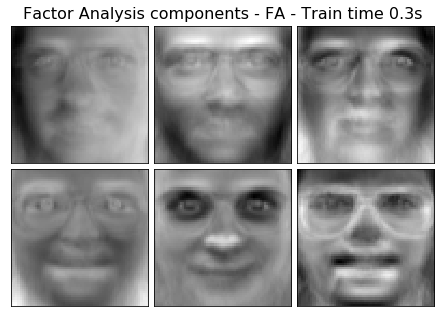

In [22]:
"""
============================
Faces dataset decompositions
============================

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .

"""
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 claus

n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)


# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF (Sklearn)',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Non-negative components - NMF (Gensim)',
     NmfWrapper(
         bow_matrix=faces.T,
         chunksize=2,
         eval_every=400,
         passes=1,
         id2word={idx: idx for idx in range(faces.shape[1])},
         num_topics=n_components,
         minimum_probability=0,
         random_state=42,
     ),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
     decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                               n_iter=50, batch_size=3,
                                               random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
     MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                     max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]

# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time.time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time.time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

As you can see, Gensim NMF implementation works as fast as Sklearn NMF and achieves comparable quality, even though it's not optimised for dense matrices.

## Conclusion

Gensim NMF is an extremely fast and memory-optimized model, and should be used whenever your system resources are too scarse for the task or when you want to try something different from LDA.